In [1]:
# disable tf warnings
import os

import numpy as np
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
tf.get_logger().setLevel('INFO')
import tensorflow_recommenders as tfrs


In [2]:
from pathlib import Path
import pandas as pd

from dataset import read_bx_csv

data_root = Path('data/BX-CSV-Dump')
users = read_bx_csv(data_root / 'BX-Users.csv')
books = read_bx_csv(data_root / 'BX-Books.csv')
ratings = read_bx_csv(data_root / 'BX-Book-Ratings.csv')

In [3]:
books.ISBN.groupby(books.ISBN).count().sort_values(ascending=False).head(10)

ISBN
0000913154    1
0812515560    1
0812514440    1
0812514459    1
0812514475    1
0812514483    1
0812515110    1
0812515129    1
0812515161    1
0812515218    1
Name: ISBN, dtype: int64

In [4]:
# get statistic of NA values values in books
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [35]:
# get statistic of NA values values in users
users.isna().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

In [37]:
users.head(100)


,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
95,96,"helsinki, alaska, finland",NaN
96,97,"mechanicsburg, pennsylvania, usa",NaN
97,98,"pukekohe, auckland, new zealand",19.0
98,99,"franktown, colorado, usa",42.0


In [5]:
books[books['Book-Author'].isna()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
118038,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...,http://images.amazon.com/images/P/0751352497.0...
187700,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...,http://images.amazon.com/images/P/9627982032.0...


In [6]:
# ''
books[books['ISBN'] == '']['ISBN'].count()


0

In [7]:
ratings_with_title = ratings.merge(books[['Book-Title', 'ISBN']], on='ISBN')

In [8]:
from dataset import filter_ratings

In [22]:
fltrd_ratings_with_title = filter_ratings(ratings_with_title)

In [24]:
fltrd_ratings_with_title.head(10)



,User-ID,Book-Title,Book-Rating
0,2313,Flesh Tones: A Novel,5
1,6543,Flesh Tones: A Novel,0
2,8680,Flesh Tones: A Novel,5
3,10314,Flesh Tones: A Novel,9
4,23768,Flesh Tones: A Novel,0
5,28523,Flesh Tones: A Novel,0
6,56157,Flesh Tones: A Novel,0
7,77480,Flesh Tones: A Novel,8
8,77940,Flesh Tones: A Novel,0
9,81977,Flesh Tones: A Novel,0


In [25]:
fltrd_ratings_with_title_200 = filter_ratings(ratings_with_title, user_ratings_max_count=200)


implicit: 208347 explicit: 111149
implicit: 132241 explicit: 91929


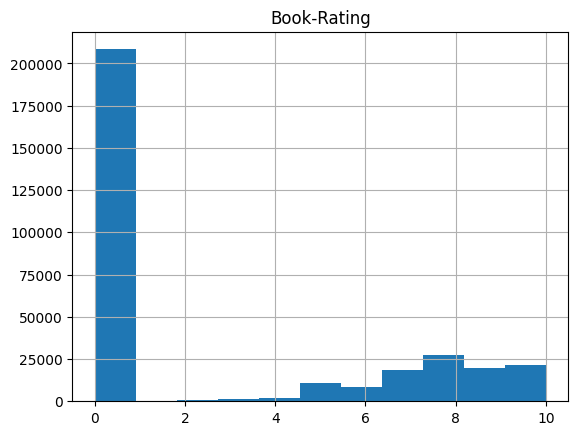

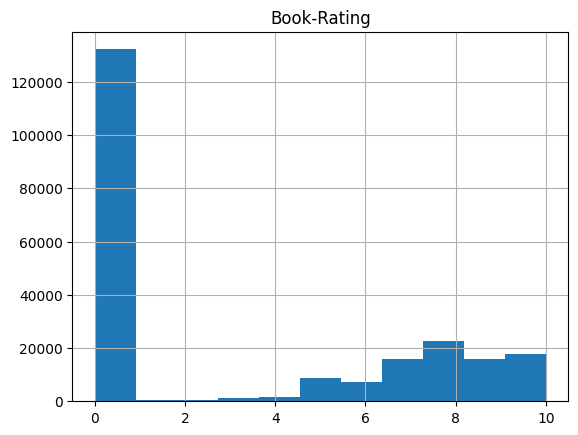

In [33]:
# plot histogram of rating values

fltrd_ratings_with_title.hist(column='Book-Rating', bins=11)
implicit_count = sum(fltrd_ratings_with_title['Book-Rating'] == 0)
print('implicit:', implicit_count, 'explicit:', len(fltrd_ratings_with_title) - implicit_count)

fltrd_ratings_with_title_200.hist(column='Book-Rating', bins=11)
implicit_count = sum(fltrd_ratings_with_title_200['Book-Rating'] == 0)
print('implicit:', implicit_count, 'explicit:', len(fltrd_ratings_with_title_200) - implicit_count)

In [17]:
from dataset import squash_user_ids
new_to_orig_user_id, orig_to_new_user_id = squash_user_ids(fltrd_ratings_with_title)

In [21]:
print(len(new_to_orig_user_id))

11206


In [18]:
# convert to tf dataset
ds_ratings_with_title = tf.data.Dataset.from_tensor_slices(dict(fltrd_ratings_with_title[['Book-Title', 'User-ID']]))
ds_book_titles = tf.data.Dataset.from_tensor_slices(fltrd_ratings_with_title['Book-Title'].unique())

In [19]:
# create stringlookup vocabs
# not needed, already int
# user_ids_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
# user_ids_vocabulary.adapt(ratings['User-ID'])

book_titles_vocabulary = tf.keras.layers.StringLookup(mask_token=None)
book_titles_vocabulary.adapt(ds_book_titles)

In [20]:
print(len(ds_book_titles), len(books))
print(len(ds_ratings_with_title), len(ratings))


6485 271379
319496 1149780


In [15]:
from typing import Dict, Text

class BookBXModel(tfrs.Model):
  # We derive from a custom base class to help reduce boilerplate. Under the hood,
  # these are still plain Keras Models.

  def __init__(
      self,
      user_model: tf.keras.Model,
      book_model: tf.keras.Model,
      task: tfrs.tasks.Retrieval):
    super().__init__()

    # Set up user and movie representations.
    self.user_model = user_model
    self.book_model = book_model

    # Set up a retrieval task.
    self.task = task

  def compute_loss(self, features: Dict[Text, tf.Tensor], training=False) -> tf.Tensor:
    # Define how the loss is computed.

    user_embeddings = self.user_model(features['User-ID'])
    book_embeddings = self.book_model(features['Book-Title'])

    return self.task(user_embeddings, book_embeddings)


In [16]:
# Define user and movie models.
user_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(unique_users), 64)
])

book_model = tf.keras.Sequential([
    book_titles_vocabulary,
    tf.keras.layers.Embedding(book_titles_vocabulary.vocabulary_size(), 64),
])

# Define your objectives.
# loss use the default, but with reduction to mean (so we can compare loss between
task = tfrs.tasks.Retrieval(
    metrics=tfrs.metrics.FactorizedTopK(candidates=ds_book_titles.batch(128).map(book_model)
))


NameError: name 'unique_users' is not defined

In [17]:

# Create a retrieval model.
model = BookBXModel(user_model, book_model, task)
model.compile(optimizer=tf.keras.optimizers.Adagrad(0.01))  # why not adam?

# Train for 3 epochs.
model.fit(ds_ratings_with_title.batch(4096), epochs=3)


Epoch 1/3
79/79 [==============================] - 231s 3s/step - factorized_top_k/top_1_categorical_accuracy: 4.3819e-05 - factorized_top_k/top_5_categorical_accuracy: 5.8530e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0013 - factorized_top_k/top_50_categorical_accuracy: 0.0076 - factorized_top_k/top_100_categorical_accuracy: 0.0152 - loss: 33218.2935 - regularization_loss: 0.0000e+00 - total_loss: 33218.2935
Epoch 2/3
79/79 [==============================] - 254s 3s/step - factorized_top_k/top_1_categorical_accuracy: 1.2833e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0018 - factorized_top_k/top_10_categorical_accuracy: 0.0036 - factorized_top_k/top_50_categorical_accuracy: 0.0175 - factorized_top_k/top_100_categorical_accuracy: 0.0323 - loss: 33208.2987 - regularization_loss: 0.0000e+00 - total_loss: 33208.2987
Epoch 3/3
79/79 [==============================] - 216s 3s/step - factorized_top_k/top_1_categorical_accuracy: 4.7575e-04 - factorized_top_k/top_5_categoric

AttributeError: module 'tensorflow_recommenders.layers' has no attribute 'ann'

In [22]:

# Use brute-force search to set up retrieval using the trained representations.
index = tfrs.layers.factorized_top_k.BruteForce(model.user_model)
# index.index(books.batch(100).map(model.book_model), books)
index.index_from_dataset(
    tf.data.Dataset.zip((ds_book_titles.batch(100), ds_book_titles.batch(100).map(model.book_model)))
    # tf.data.Dataset.zip(ds_book_titles.batch(100), ds_book_titles.batch(100).map(model.book_model))
)

# Get some recommendations.
_, titles = index(np.array([0]))
print(f"Top 3 recommendations for user 0: {titles[0, :3]}")

Top 3 recommendations for user 0: [b'Rising Sun' b'Bel Canto: A Novel' b'Driving Force']


In [29]:

# Create a retrieval model.
model = BookBXModel(user_model, book_model, task)
model.compile(optimizer=tf.keras.optimizers.Adam(0.01))  # why not adam?

# Train for 3 epochs.
model.fit(ds_ratings_with_title.batch(4096), epochs=3)


Epoch 1/3
79/79 [==============================] - 174s 2s/step - factorized_top_k/top_1_categorical_accuracy: 2.8795e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0026 - factorized_top_k/top_10_categorical_accuracy: 0.0053 - factorized_top_k/top_50_categorical_accuracy: 0.0222 - factorized_top_k/top_100_categorical_accuracy: 0.0387 - loss: 33142.7286 - regularization_loss: 0.0000e+00 - total_loss: 33142.7286
Epoch 2/3
79/79 [==============================] - 239s 3s/step - factorized_top_k/top_1_categorical_accuracy: 0.0037 - factorized_top_k/top_5_categorical_accuracy: 0.0194 - factorized_top_k/top_10_categorical_accuracy: 0.0311 - factorized_top_k/top_50_categorical_accuracy: 0.0746 - factorized_top_k/top_100_categorical_accuracy: 0.1078 - loss: 32066.3732 - regularization_loss: 0.0000e+00 - total_loss: 32066.3732
Epoch 3/3
79/79 [==============================] - 170s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy:

In [33]:
# Create a retrieval model.
model = BookBXModel(user_model, book_model, task)

epochs = 15
#cosine schedule
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=0.05,
            decay_steps=epochs * len(ds_ratings_with_title) // 4096,
        ),
    )
)

# Train for 3 epochs.
model.fit(ds_ratings_with_title.batch(4096), epochs=epochs)


Epoch 1/15
79/79 [==============================] - 160s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0058 - factorized_top_k/top_5_categorical_accuracy: 0.0267 - factorized_top_k/top_10_categorical_accuracy: 0.0418 - factorized_top_k/top_50_categorical_accuracy: 0.1079 - factorized_top_k/top_100_categorical_accuracy: 0.1626 - loss: 29552.6832 - regularization_loss: 0.0000e+00 - total_loss: 29552.6832
Epoch 2/15
79/79 [==============================] - 159s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0089 - factorized_top_k/top_5_categorical_accuracy: 0.0377 - factorized_top_k/top_10_categorical_accuracy: 0.0601 - factorized_top_k/top_50_categorical_accuracy: 0.1509 - factorized_top_k/top_100_categorical_accuracy: 0.2154 - loss: 29871.5131 - regularization_loss: 0.0000e+00 - total_loss: 29871.5131
Epoch 3/15
79/79 [==============================] - 161s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0123 - factorized_top_k/top_5_categorical_accuracy: 

# divide dataset into train and test

In [82]:
def train_model(train, test, model, epochs, batch_size, lr=0.01, cosine_decay=False):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            tf.keras.optimizers.schedules.CosineDecay(
                initial_learning_rate=lr,
                decay_steps=epochs * len(train) // batch_size,
            ) if cosine_decay

            else lr
        )
    )
    model.fit(train.batch(batch_size),  # todo forgot to shuffle
              validation_data=test.batch(batch_size),
              epochs=epochs,
                callbacks=[tensorboard_callback]
              )
    return model

In [50]:
from dataset import train_test_split

In [40]:
# Create a retrieval model.
model = BookBXModel(user_model, book_model, task)

epochs = 15
batch_size = 4096
#cosine schedule
model.compile(
    optimizer=tf.keras.optimizers.Adam(
        tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=0.01,
            decay_steps=epochs * len(train) // batch_size,
        ),
    )
)

model.fit(train.batch(batch_size),
          validation_data=test.batch(batch_size),
          epochs=epochs)


Epoch 1/15
63/63 [==============================] - 146s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0151 - factorized_top_k/top_5_categorical_accuracy: 0.0957 - factorized_top_k/top_10_categorical_accuracy: 0.1513 - factorized_top_k/top_50_categorical_accuracy: 0.3074 - factorized_top_k/top_100_categorical_accuracy: 0.3924 - loss: 26511.7045 - regularization_loss: 0.0000e+00 - total_loss: 26511.7045 - val_factorized_top_k/top_1_categorical_accuracy: 9.3897e-05 - val_factorized_top_k/top_5_categorical_accuracy: 0.0030 - val_factorized_top_k/top_10_categorical_accuracy: 0.0088 - val_factorized_top_k/top_50_categorical_accuracy: 0.0572 - val_factorized_top_k/top_100_categorical_accuracy: 0.1033 - val_loss: 20606.7852 - val_regularization_loss: 0.0000e+00 - val_total_loss: 20606.7852
Epoch 2/15
63/63 [==============================] - 144s 2s/step - factorized_top_k/top_1_categorical_accuracy: 0.0116 - factorized_top_k/top_5_categorical_accuracy: 0.1113 - factorized_top_k/top

In [76]:
import dataset
import importlib
importlib.reload(dataset)


<module 'dataset' from '/Users/adam/datasentics-uloha/dataset.py'>

In [79]:
ratings_with_title_user_less_200 = filter_ratings(ratings_with_title, user_ratings_max_count=200)
from dataset import squash_user_ids
new_to_orig_user_id, orig_to_new_user_id = squash_user_ids(ratings_with_title_user_less_200)


In [80]:
len(ratings_with_title_user_less_200)

224170

In [81]:
train_model(*train_test_split(ratings_with_title_user_less_200[['Book-Title', 'User-ID']]), model, epochs=15, batch_size=4096, lr=0.01, cosine_decay=True)

Epoch 1/15
44/44 [==============================] - 102s 2s/step - factorized_top_k/top_1_categorical_accuracy: 1.2267e-04 - factorized_top_k/top_5_categorical_accuracy: 9.8697e-04 - factorized_top_k/top_10_categorical_accuracy: 0.0024 - factorized_top_k/top_50_categorical_accuracy: 0.0129 - factorized_top_k/top_100_categorical_accuracy: 0.0268 - loss: 53310.5327 - regularization_loss: 0.0000e+00 - total_loss: 53310.5327 - val_factorized_top_k/top_1_categorical_accuracy: 1.7844e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0013 - val_factorized_top_k/top_10_categorical_accuracy: 0.0030 - val_factorized_top_k/top_50_categorical_accuracy: 0.0157 - val_factorized_top_k/top_100_categorical_accuracy: 0.0321 - val_loss: 44607.2617 - val_regularization_loss: 0.0000e+00 - val_total_loss: 44607.2617
Epoch 2/15
44/44 [==============================] - 84s 2s/step - factorized_top_k/top_1_categorical_accuracy: 4.9070e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0043 - factorize

KeyboardInterrupt: 

In [83]:
train_model(*train_test_split(ratings_with_title_user_less_200[['Book-Title', 'User-ID']]), model, epochs=15, batch_size=2000, lr=0.0025, cosine_decay=False)

Epoch 1/15
90/90 [==============================] - 114s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0032 - factorized_top_k/top_5_categorical_accuracy: 0.1013 - factorized_top_k/top_10_categorical_accuracy: 0.1688 - factorized_top_k/top_50_categorical_accuracy: 0.3702 - factorized_top_k/top_100_categorical_accuracy: 0.4780 - loss: 10646.3035 - regularization_loss: 0.0000e+00 - total_loss: 10646.3035 - val_factorized_top_k/top_1_categorical_accuracy: 2.0074e-04 - val_factorized_top_k/top_5_categorical_accuracy: 0.0023 - val_factorized_top_k/top_10_categorical_accuracy: 0.0086 - val_factorized_top_k/top_50_categorical_accuracy: 0.0603 - val_factorized_top_k/top_100_categorical_accuracy: 0.1119 - val_loss: 33649.0703 - val_regularization_loss: 0.0000e+00 - val_total_loss: 33649.0703
Epoch 2/15
90/90 [==============================] - 98s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0030 - factorized_top_k/top_5_categorical_accuracy: 0.1114 - factorized_top_k/top_

KeyboardInterrupt: 

In [84]:
train_model(*train_test_split(ratings_with_title_user_less_200[['Book-Title', 'User-ID']]), model, epochs=15, batch_size=2000, lr=0.005, cosine_decay=False)

Epoch 1/15
90/90 [==============================] - 95s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0044 - factorized_top_k/top_5_categorical_accuracy: 0.1337 - factorized_top_k/top_10_categorical_accuracy: 0.2331 - factorized_top_k/top_50_categorical_accuracy: 0.4873 - factorized_top_k/top_100_categorical_accuracy: 0.5984 - loss: 9535.5077 - regularization_loss: 0.0000e+00 - total_loss: 9535.5077 - val_factorized_top_k/top_1_categorical_accuracy: 6.6914e-05 - val_factorized_top_k/top_5_categorical_accuracy: 0.0018 - val_factorized_top_k/top_10_categorical_accuracy: 0.0076 - val_factorized_top_k/top_50_categorical_accuracy: 0.0642 - val_factorized_top_k/top_100_categorical_accuracy: 0.1225 - val_loss: 34926.2031 - val_regularization_loss: 0.0000e+00 - val_total_loss: 34926.2031
Epoch 2/15
90/90 [==============================] - 104s 1s/step - factorized_top_k/top_1_categorical_accuracy: 0.0063 - factorized_top_k/top_5_categorical_accuracy: 0.1441 - factorized_top_k/top_10

KeyboardInterrupt: 